# Sky chart on 360° panorama

## Introduction

This script takes a sky chart and a 360° panorama of an horizon and merges the sky chart to the horizon. This allows to view the sky chart in the context of your panorama. Through a 360° image viewer, or by importing the image in Stellarium, you can then take a look at your sky chart with your phone with AR/VR.

I created this code to see the ISS path of a pass in my horizon and plan my observations. Thanks to it, I can precisely see where the ISS will appear and what path it will follow in the sky.

The images should follow a specific format :
* Horizon panorama : 
    - 360° azimuth on the width of the image, from -180° (left) to +180° (right), with North in the center (although this can be changed with the `left_az` argument in the `unfold_hemisphere` function)
    - 180° altitude on the height of the image, from -90° (bottom) to +90° (top), with horizon in the center
    - It can be created with the [360 Photo Sphere Camera](https://play.google.com/store/apps/details?id=com.foxpoi.panorama&hl=en_US) Android app
    - The sky must have been removed and made transparent (png image with transparence), with GIMP or Photoshop (or any other software)
* Sky chart :
    - Polar map with North on top, and azimuth rotating counterclockwise (looking at the sky : East on the left, West on the right)
    - Full 360° azimuth and 0°-90° altitude ranges
    - Sky charts generated by [Heavens-Above](https://heavens-above.com) follow this format

## Code

I used `numpy`, `matplotlib.pyplot` and `cv2` (OpenCV) to view and manipulate the images. Therefore, you must install these librairies to run this script :
* `pip install numpy`
* `pip install matplotlib`
* `pip install opencv-python`

To load the two images, you just have to change the filenames in the `cv2.imread` functions at the beginning, either with a full path, or a relative path in the images are in the same folder as this code.

In [1]:
# Importing librairies
import numpy as np
import matplotlib.pyplot as plt
import cv2

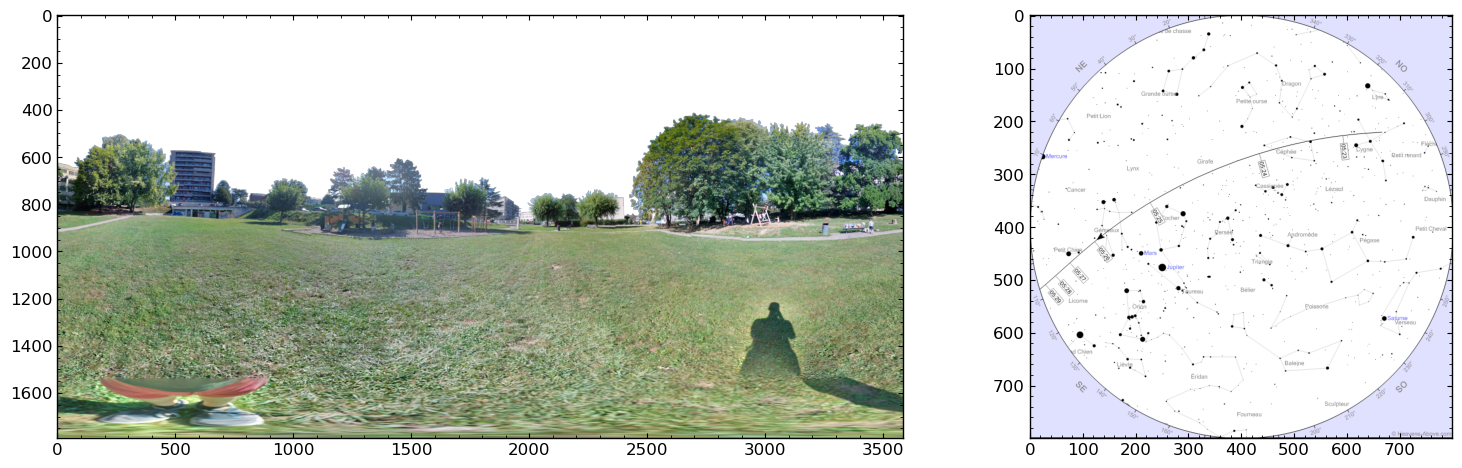

In [15]:
# Loading base images
panorama = cv2.imread("Images/Panorama.png", cv2.IMREAD_UNCHANGED)
skychart = cv2.imread("Images/HeavensAbove.png")
left_az = 0 #Azimuth of the left edge of panorama

# Displaying base images
plt.subplots(1,2,figsize=(18,8), gridspec_kw={'width_ratios': [2, 1]})
plt.subplot(121)
plt.imshow(panorama[:,:,[2,1,0,3]])
plt.subplot(122)
plt.imshow(skychart[:,:,::-1])

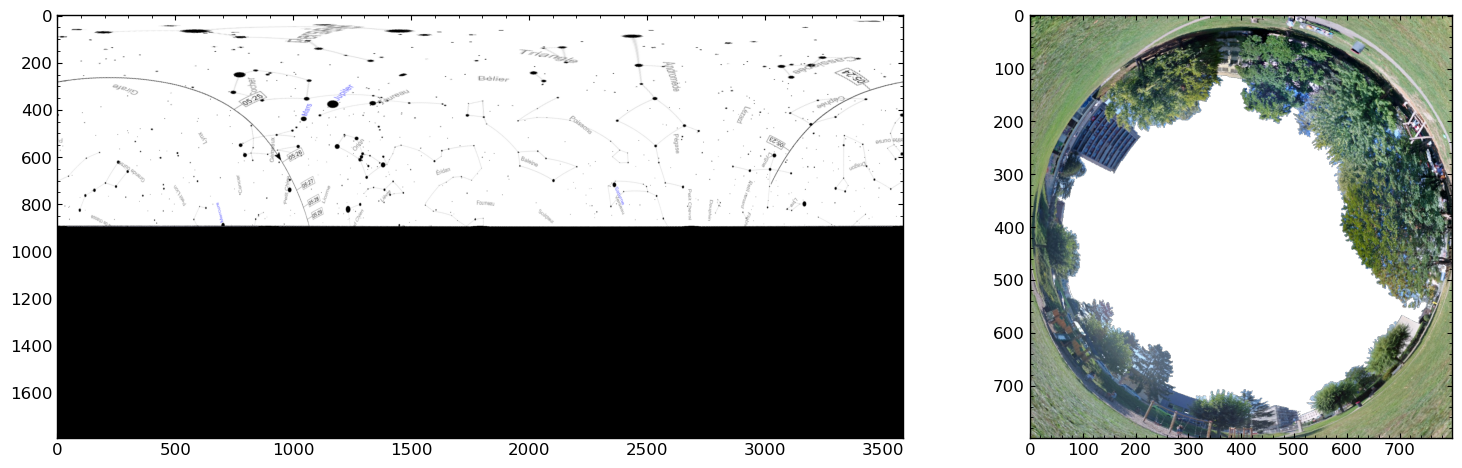

In [16]:
def unfold_hemisphere(hemisphere, flat, alt_range=(0,90), left_az=0):
    # Unfold the hemisphere image (sky chart) and maps it to a flat image (panorama)
    # For each pixel of the flat image, it calculates the corresponding altitude and azimtuh corresponding
    # It then calculates the corresponding pixel in the hemisphere map
    # This function uses numpy to accelerate the calculations
    # flat : Image with altaz (90, left_az) at [0,0] and (-90, left_az+360) at [h,w]
    h,w,_ = flat.shape
    h_hemi,w_hemi,_ = hemisphere.shape
    alt_flat = np.linspace(alt_range[1], alt_range[0], h//2) # Altitudes range from 0° (h//2) to +90° (0)
    az_flat = np.linspace(left_az, left_az+360, w) # Azimuth range from -180° (0) to +180° (w)
    AZ_flat, ALT_flat = np.meshgrid(az_flat, alt_flat) # Meshgrid of altitude and azimuth
    DIST_ALT = (90-ALT_flat)*w_hemi/180 # Calculates distance from center of hemisphere map 
    AZ_RAD = AZ_flat*np.pi/180 # Calculates angle from center of hemisphere map
    X = w_hemi/2 - DIST_ALT*np.sin(AZ_RAD) # x coordinate in hemisphere map
    Y = h_hemi/2 - DIST_ALT*np.cos(AZ_RAD) # y coordinate in hemisphere map
    J = np.clip(X.astype(int),0,w_hemi-1) # row index in hemisphere map
    I = np.clip(Y.astype(int),0,h_hemi-1) # col index in hemisphere map
    flat[:flat.shape[0]//2,:] = hemisphere[I,J] # Maps pixels from hemisphere to the flat image

def fold_flat(flat, hemisphere, left_az=0):
    # Fold the flat image (panorama) and maps it to a hemisphere image (sky chart)
    # For each pixel of the hemisphere image, it calculates the corresponding altitude and azimtuh
    # It then calculates the corresponding pixel in the flat map
    # This function uses numpy to accelerate the calculations
    # flat : Image with altaz (90,-180) at [0,0] and (-90,180) at [h,w]
    h,w,_ = flat.shape
    h_hemi,w_hemi,_ = hemisphere.shape
    x_hemi = np.arange(w_hemi) # x range in hemisphere
    y_hemi = np.arange(h_hemi) # y range in hemisphere
    X_hemi, Y_hemi = np.meshgrid(x_hemi, y_hemi) # Meshgrid of x and y
    AZ = np.arctan2(-X_hemi+w_hemi/2, -Y_hemi+h_hemi/2)*180/np.pi # Calculates azimuth from center of hemisphere map
    ALT = 90 - np.sqrt((X_hemi-w_hemi/2)**2+(Y_hemi-h_hemi/2)**2)*180/w_hemi # Calculates altitude from hemisphere map 
    X_flat = w/2 + (AZ+180+left_az)*w/360 # x coordinate in flat map
    Y_flat = h/2 - ALT*h/180 # y coordinate in flat map
    J = X_flat.astype(int)%(w-1) # row index in flat map
    I = Y_flat.astype(int)%(h-1) # col index in flat map
    hemisphere[:,:,:] = flat[I,J] # Maps pixels from flat to hemisphere

flat = np.zeros_like(panorama[:,:,[0,1,2]],dtype=np.uint8)
unfold_hemisphere(skychart,flat, left_az=left_az)

hemisphere = np.zeros((skychart.shape[0], skychart.shape[1], 4),dtype=np.uint8)
fold_flat(panorama,hemisphere, left_az=left_az)

plt.subplots(1,2,figsize=(18,8), gridspec_kw={'width_ratios': [2, 1]})
plt.subplot(121)
plt.imshow(flat[:,:,::-1])
plt.subplot(122)
plt.imshow(hemisphere[:,:,[2,1,0,3]])

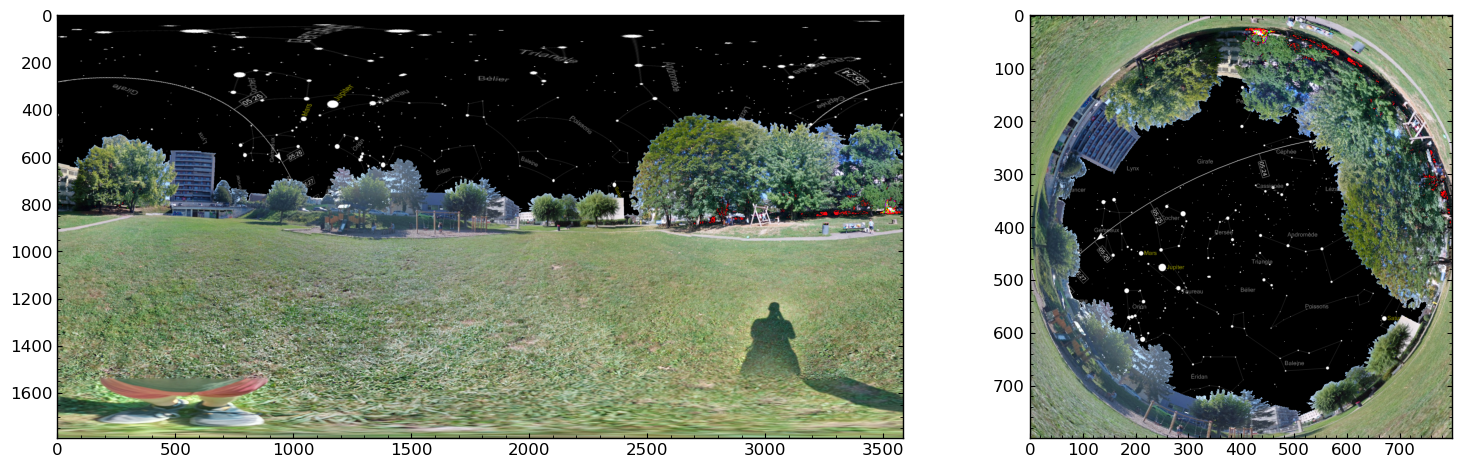

In [17]:
def stack_horizon(panorama, flat, invert=True):
    # Stacks the flat unfolded hemipshere on the horizon panorama using the alpha channel
    # invert : Inverts the color of the sky chart
    non_transparent = 255*(panorama[:,:,3]!=0).astype("uint8") # Finds non-transparent pixel in the panorama
    panorama_clean = panorama[:,:,[0,1,2]] # Removes alpha channel in the panorama
    panorama_clean = cv2.bitwise_and(panorama_clean, panorama_clean, mask=non_transparent) # Makes the previously transparent pixels black
    flat_clean = cv2.bitwise_and(flat, flat, mask=cv2.bitwise_not(non_transparent)) # Uses the horizon as a mask for the flat image
    if invert: flat_clean = ~flat_clean # Inverts flat image
    img = flat_clean+panorama_clean # Adds horizon and sky
    return img

flat_map = stack_horizon(panorama, flat, invert=True)
hemisphere_map = stack_horizon(hemisphere, skychart, invert=True)
cv2.imwrite("Output/Trace_Flat.png", flat_map)
cv2.imwrite("Output/Trace_Polar.png", hemisphere_map)
plt.subplots(1,2,figsize=(18,8), gridspec_kw={'width_ratios': [2, 1]})
plt.subplot(121)
plt.imshow(flat_map[:,:,::-1])
plt.subplot(122)
plt.imshow(hemisphere_map[:,:,::-1])

## Credit and license

By Aurélien Genin (https://github.com/AstroAure)

Copyright : CC-BY-SA